# **Pemodelan Analisis Sentimen Menggunakan Deep Learning (LSTM)**

Notebook ini berisi proses pemodelan analisis sentimen menggunakan pendekatan Deep Learning dengan arsitektur Long Short-Term Memory (LSTM). Tahapan meliputi pembuatan model baseline LSTM, evaluasi performa model, serta penyimpanan model dan tokenizer untuk keperluan inferensi dan integrasi ke aplikasi GUI.

## **Import Library**

In [58]:
# Install library untuk hyperparameter tuning
!pip install -U keras-tuner
!pip install deep-translator
!pip install deep-translator tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 4.7 MB/s eta 0:00:00


In [28]:
# Import library untuk manipulasi data dan deep learning
import pandas as pd
import numpy as np
import pickle
import os

# Preprocessing teks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# NLP augmentation
from deep_translator import GoogleTranslator
from tqdm import tqdm

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

# Evaluasi model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight

# Hyperparameter tuning
import keras_tuner as kt

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Bersihkan folder tuner jika ada hasil tuning lama
import shutil
shutil.rmtree('tuner_dir/lstm_sentiment', ignore_errors=True)

## **Load Dataset Hasil Preprocessing**

In [2]:
# Memuat dataset preprocessing
df = pd.read_csv('dataset_preprocessed.csv')

# Menampilkan ukuran dataset
print("Jumlah data (baris, kolom):", df.shape)
df.head()

Jumlah data (baris, kolom): (40384, 2)


,clean_text,sentiment_num
0,barang sesuai pesan cepat,1
1,barang bagus harga murah,1
2,paket rapimantapcepatsampe tuju,1
3,ya puas dgn barang,1
4,responya b mantap,1


## **Label Encoding untuk Deep Learning**

In [3]:
# Map label untuk deep learning: -1 -> 0, 0 -> 1, 1 -> 2
label_mapping = {-1:0, 0:1, 1:2}
df['sentiment_dl'] = df['sentiment_num'].map(label_mapping)

# Preview kolom encoding
df[['sentiment_num', 'sentiment_dl']].head()

,sentiment_num,sentiment_dl
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2


## **Distribusi Kelas Sentimen**

/tmp/ipython-input-1980016238.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Positive', 'Neutral', 'Negative'])


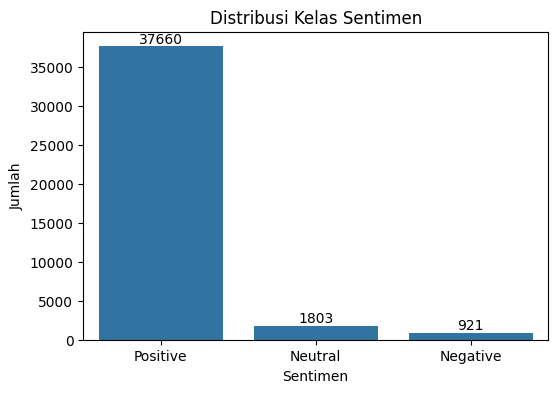

In [5]:
# Visualisasi distribusi kelas sentiment
plt.figure(figsize=(6,4))
ax = sns.countplot(
    x='sentiment_num',
    data=df,
    order=[1, 0, -1]
)

# Ganti label numerik menjadi teks
ax.set_xticklabels(['Positive', 'Neutral', 'Negative'])

plt.title('Distribusi Kelas Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

# Tambahkan jumlah data di atas bar
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()

## **Split Data (Training & Testing)**

In [6]:
# Menentukan fitur (X) dan label (y)
X = df['clean_text']
y = df['sentiment_dl']

# Membagi data menjadi data training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    # untuk menjaga proporsi kelas sentimen
    stratify=y
)

print("Jumlah data training:", X_train.shape[0])
print("Jumlah data testing :", X_test.shape[0])

Jumlah data training: 32307
Jumlah data testing : 8077


## **Data Augmentation untuk Minoritas**

In [7]:
# Fungsi back translation
def back_translate(text):
    try:
        # Indonesia -> Inggris -> Indonesia
        en_text = GoogleTranslator(source='id', target='en').translate(text)
        id_text = GoogleTranslator(source='en', target='id').translate(en_text)
        return id_text
    except:
        return text  # jika gagal, kembalikan teks asli

# Cek apakah sudah pernah disimpan
import os
aug_file = 'augmented_minoritas.csv'

if os.path.exists(aug_file):
    print("Loading augmentasi dari cache...")
    aug_data = pd.read_csv(aug_file)
else:
    print("Melakukan augmentasi minoritas (back translation)...")
    # Ambil data minoritas
    neg_texts = X_train[y_train == 0].tolist()
    neu_texts = X_train[y_train == 1].tolist()

    # Augmentasi dengan progress bar
    neg_aug = [back_translate(t) for t in tqdm(neg_texts, desc="Negative")]
    neu_aug = [back_translate(t) for t in tqdm(neu_texts, desc="Neutral")]

    # Gabungkan ke dataframe
    aug_data = pd.DataFrame({
        'text': neg_aug + neu_aug,
        'label': [0]*len(neg_aug) + [1]*len(neu_aug)
    })

    # Simpan hasil augmentasi supaya tidak perlu ulangi
    aug_data.to_csv(aug_file, index=False)

# Gabungkan dengan X_train & y_train
X_train = pd.concat([X_train, aug_data['text']], ignore_index=True)
y_train = pd.concat([y_train, aug_data['label']], ignore_index=True)

print("Distribusi kelas setelah augmentasi:")
print(y_train.value_counts())

Melakukan augmentasi minoritas (back translation)...


Neutral: 100%|██████████| 1442/1442 [32:43<00:00,  1.36s/it]

Distribusi kelas setelah augmentasi:
2    30128
1     2884
0     1474
Name: count, dtype: int64


## **Integrasi Data Augmentasi + Shuffle**

In [16]:
# Simpan data asli train sebelum augmentasi
X_train_orig = X_train.copy()
y_train_orig = y_train.copy()

# Load augmentasi
aug_data = pd.read_csv('augmented_minoritas.csv')

# Gabungkan dengan data asli saja
X_train = pd.concat([X_train_orig, aug_data['text']], ignore_index=True)
y_train = pd.concat([y_train_orig, aug_data['label']], ignore_index=True)

# Shuffle
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = train_df['text']
y_train = train_df['label']

print("Distribusi kelas setelah augmentasi & shuffle:")
print(y_train.value_counts())

Distribusi kelas setelah augmentasi & shuffle:
label
2    30128
1     5768
0     2948
Name: count, dtype: int64


## **Tokenization & Padding**

In [17]:
# Tentukan maksimum kata dan panjang sequence
max_words = 20000
max_len = 150

# Tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Transformasi teks menjadi sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

# Padding sequence agar panjang sama
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

## **Simpan Tokenizer**

In [18]:
# Simpan tokenizer
with open('tokenizer_sentiment.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Baseline model dan tokenizer berhasil disimpan.")

Baseline model dan tokenizer berhasil disimpan.


## **Build Baseline LSTM Model**

Model LSTM digunakan sebagai baseline deep learning untuk membandingkan performanya dengan Logistic Regression.

In [19]:
# Jumlah kelas
num_classes = 3

# Model Sequential
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    LSTM(256, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile model
lstm_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan summary
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Hitung Class Weight

In [20]:
# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Jika ingin menjadi dictionary
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: [4.39213026 2.24479889 0.42976633]


### Training LSTM Baseline Model dengan Early Stopping

In [21]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Pantau loss di data validasi
    patience=3,               # Hentikan training jika 3 epoch berturut-turut tidak membaik
    restore_best_weights=True # Kembalikan bobot terbaik
)

# ModelCheckpoint callback untuk menyimpan model terbaik otomatis
checkpoint = ModelCheckpoint(
    'best_model_lstm.h5',    # nama file model yang disimpan
    monitor='val_accuracy',  # pantau validation accuracy
    verbose=1,
    save_best_only=True,     # hanya simpan model terbaik
    mode='max'
)

# Training model
history = lstm_model.fit(
    X_train_pad,
    y_train,
    validation_split=0.2,    # Gunakan 20% data training untuk validasi
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, checkpoint],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/15
971/972 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3043 - loss: 1.1018
Epoch 1: val_accuracy improved from -inf to 0.07672, saving model to best_model_lstm.h5


972/972 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3044 - loss: 1.1018 - val_accuracy: 0.0767 - val_loss: 1.1036
Epoch 2/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3138 - loss: 1.0978
Epoch 2: val_accuracy improved from 0.07672 to 0.77243, saving model to best_model_lstm.h5


972/972 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3140 - loss: 1.0977 - val_accuracy: 0.7724 - val_loss: 0.8414
Epoch 3/15
971/972 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7647 - loss: 0.9083
Epoch 3: val_accuracy did not improve from 0.77243
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7648 - loss: 0.9083 - val_accuracy: 0.7672 - val_loss: 0.6734
Epoch 4/15
971/972 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7824 - loss: 0.7847
Epoch 4: val_accuracy did not improve from 0.77243
972/972 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.7824 - loss: 0.7847 - val_accuracy: 0.7301 - val_loss: 0.6863
Epoch 5/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8133 - loss: 0.7201
Epoch 5: val_accuracy improved from 0.77243 to 0.83074, saving model to best_model_lstm.h5


972/972 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.8133 - loss: 0.7201 - val_accuracy: 0.8307 - val_loss: 0.5110
Epoch 6/15
970/972 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8556 - loss: 0.5692
Epoch 6: val_accuracy did not improve from 0.83074
972/972 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.8556 - loss: 0.5692 - val_accuracy: 0.8239 - val_loss: 0.5182
Epoch 7/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8947 - loss: 0.4492
Epoch 7: val_accuracy did not improve from 0.83074
972/972 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.8947 - loss: 0.4492 - val_accuracy: 0.8175 - val_loss: 0.5470
Epoch 8/15
970/972 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9162 - loss: 0.3492
Epoch 8: val_accuracy improved from 0.83074 to 0.85622, saving model to best_model_lstm.h5


972/972 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9162 - loss: 0.3492 - val_accuracy: 0.8562 - val_loss: 0.4293
Epoch 9/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9309 - loss: 0.3058
Epoch 9: val_accuracy did not improve from 0.85622
972/972 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9309 - loss: 0.3058 - val_accuracy: 0.8495 - val_loss: 0.4824
Epoch 10/15
972/972 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9426 - loss: 0.2743
Epoch 10: val_accuracy improved from 0.85622 to 0.85983, saving model to best_model_lstm.h5


972/972 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9425 - loss: 0.2743 - val_accuracy: 0.8598 - val_loss: 0.4350
Epoch 11/15
970/972 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9415 - loss: 0.2399
Epoch 11: val_accuracy improved from 0.85983 to 0.86601, saving model to best_model_lstm.h5


972/972 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9415 - loss: 0.2399 - val_accuracy: 0.8660 - val_loss: 0.4543


### Evaluasi Baseline LSTM

In [22]:
# Prediksi data training & testing
y_train_pred = lstm_model.predict(X_train_pad).argmax(axis=1)
y_test_pred  = lstm_model.predict(X_test_pad).argmax(axis=1)

# Hitung akurasi
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)
f1_macro = f1_score(y_test, y_test_pred, average='macro')

print("Baseline LSTM Performance")
print("-------------------------")
print("Training Accuracy :", train_acc)
print("Testing Accuracy  :", test_acc)
print("Macro F1 Score (Testing):", f1_macro)

# Classification report untuk data testing
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Negative','Neutral','Positive']))

1214/1214 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Baseline LSTM Performance
-------------------------
Training Accuracy : 0.9248532591906086
Testing Accuracy  : 0.8552680450662374
Macro F1 Score (Testing): 0.48528026898889215

Classification Report:
              precision    recall  f1-score   support

    Negative       0.34      0.40      0.37       184
     Neutral       0.12      0.27      0.16       361
    Positive       0.96      0.89      0.93      7532

    accuracy                           0.86      8077
   macro avg       0.47      0.52      0.49      8077
weighted avg       0.91      0.86      0.88      8077



### Confusion Matrix Baseline

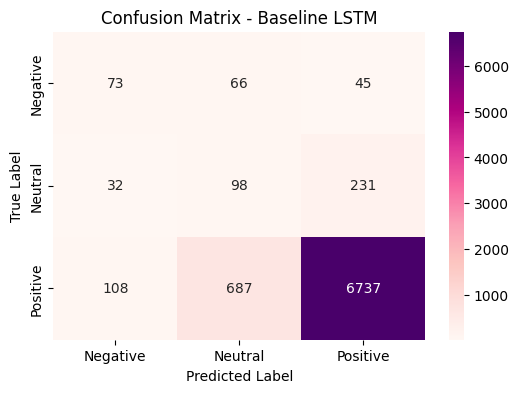

In [23]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='RdPu',
    xticklabels=['Negative','Neutral','Positive'],
    yticklabels=['Negative','Neutral','Positive']
)
plt.title('Confusion Matrix - Baseline LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **Hyperparameter Tuning LSTM**

### Custom Macro F1 Callback

In [29]:
class F1MetricCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data  # tuple (X_val, y_val)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        X_val, y_val = self.validation_data  # ambil data validasi
        y_pred = np.argmax(self.model.predict(X_val), axis=1)  # prediksi label
        f1 = f1_score(y_val, y_pred, average='macro')  # hitung macro F1
        logs['val_macro_f1'] = f1  # simpan ke logs
        print(f" - val_macro_f1: {f1:.4f}")  # print macro F1 per epoch

### Build Model Function untuk Tuning

In [30]:
def build_model(hp):
    model = Sequential()

    # Layer embedding
    model.add(Embedding(
        input_dim=max_words,  # jumlah kata maksimum
        output_dim=hp.Int('embed_dim', 64, 256, 32)  # dimensi embedding dicari tuner
    ))

    # Layer LSTM
    model.add(LSTM(
        units=hp.Int('lstm_units', 32, 128, 32)  # jumlah unit LSTM
    ))

    # Dropout untuk regularisasi
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, 0.1)))  # dropout rate

    # Dense layer untuk hidden
    model.add(Dense(
        hp.Int('dense_units', 16, 64, 16),  # jumlah neuron dense layer
        activation='relu'
    ))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))  # multi-class output

    # Compile model
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),  # learning rate dari tuner
        loss='sparse_categorical_crossentropy',  # loss untuk multi-class
        metrics=['accuracy']  # metric utama accuracy
    )

    return model

### Split Validation dari Training

In [31]:
X_train_pad_tuner, X_val_pad, y_train_tuner, y_val = train_test_split(
    X_train_pad,  # input train
    y_train,      # label train
    test_size=0.2,  # 20% untuk validation
    random_state=42,
    stratify=y_train  # jaga proporsi kelas tetap sama
)

### Inisialisasi & Jalankan Tuner

In [32]:
# Inisialisasi tuner
tuner = kt.RandomSearch(
    build_model,                # fungsi build model
    objective='val_accuracy',   # metric yang ingin dioptimasi
    max_trials=5,               # jumlah percobaan hyperparameter
    executions_per_trial=1,     # eksekusi tiap trial
    directory='tuner_dir',      # folder simpan tuner
    project_name='lstm_sentiment'  # nama project
)

# Callback untuk macro F1
f1_callback = F1MetricCallback(validation_data=(X_val_pad, y_val))

# Jalankan tuner
tuner.search(
    X_train_pad_tuner,  # data training
    y_train_tuner,      # label training
    validation_data=(X_val_pad, y_val),  # data validasi
    epochs=15,          # jumlah epoch maksimal
    batch_size=32,      # batch size
    callbacks=[EarlyStopping(monitor='val_loss', patience=3), f1_callback]  # early stopping + macro F1
)

Trial 5 Complete [00h 01m 19s]
val_accuracy: 0.7756468057632446

Best val_accuracy So Far: 0.7756468057632446
Total elapsed time: 00h 07m 05s


### Ambil Model Terbaik & Evaluasi

In [33]:
# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# Prediksi pada train dan test
y_train_pred_best = best_model.predict(X_train_pad).argmax(axis=1)
y_test_pred_best  = best_model.predict(X_test_pad).argmax(axis=1)

# Hitung akurasi & F1
train_acc_best = accuracy_score(y_train, y_train_pred_best)
test_acc_best  = accuracy_score(y_test, y_test_pred_best)
f1_macro_best  = f1_score(y_test, y_test_pred_best, average='macro')

# Print hasil evaluasi
print("Tuned LSTM Model Performance")
print("----------------------------")
print("Training Accuracy :", train_acc_best)
print("Testing Accuracy  :", test_acc_best)
print("Macro F1 Score (Testing):", f1_macro_best)
print("\nClassification Report (Testing Data):")
print(classification_report(y_test, y_test_pred_best, target_names=['Negative','Neutral','Positive']))

   1/1214 ━━━━━━━━━━━━━━━━━━━━ 2:30 124ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Tuned LSTM Model Performance
----------------------------
Training Accuracy : 0.775615281639378
Testing Accuracy  : 0.9325244521480748
Macro F1 Score (Testing): 0.3216947487560595

Classification Report (Testing Data):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       184
     Neutral       0.00      0.00      0.00       361
    Positive       0.93      1.00      0.97      7532

    accuracy                           0.93      8077
   macro avg       0.31      0.33      0.32      8077
weighted avg       0.87      0.93      0.90      8077



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix Tuned

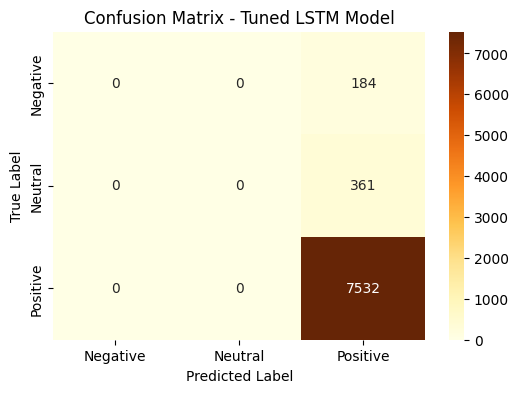

In [34]:
cm_best = confusion_matrix(y_test, y_test_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.title('Confusion Matrix - Tuned LSTM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Simpan Model Terbaik Hasil Tuning

In [35]:
best_model.save('best_model_lstm_tuned.h5')  # simpan model
print("Tuned model berhasil disimpan.")

Tuned model berhasil disimpan.
